In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Dict, Any
from itertools import product
from collections import Counter
from tqdm import tqdm
from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.runs import runstest_1samp
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.interpolate import interp1d
from scipy.stats import  gaussian_kde
from scipy.stats import ks_2samp

In [2]:
apple = pd.read_csv(r"D:\data\notebooks\week-10\cleaned_apple_high_low.csv")
apple['DATE'] = pd.to_datetime(apple['DATE'], errors='coerce')
apple = apple.sort_values('DATE')
apple.head()

,DATE,weekday,OPEN,CLOSE,VOL,HIGH,LOW
0,1984-09-07,Friday,0.10122,0.10122,97236149.0,0.10246,0.10000
1,1984-09-10,Monday,0.10122,0.10062,75471114.0,0.10153,0.09878
2,1984-09-11,Tuesday,0.10153,0.10246,177965367.0,0.10428,0.10153
3,1984-09-12,Wednesday,0.10246,0.09938,155467926.0,0.10306,0.09938
4,1984-09-13,Thursday,0.10490,0.10490,242135546.0,0.10520,0.10490


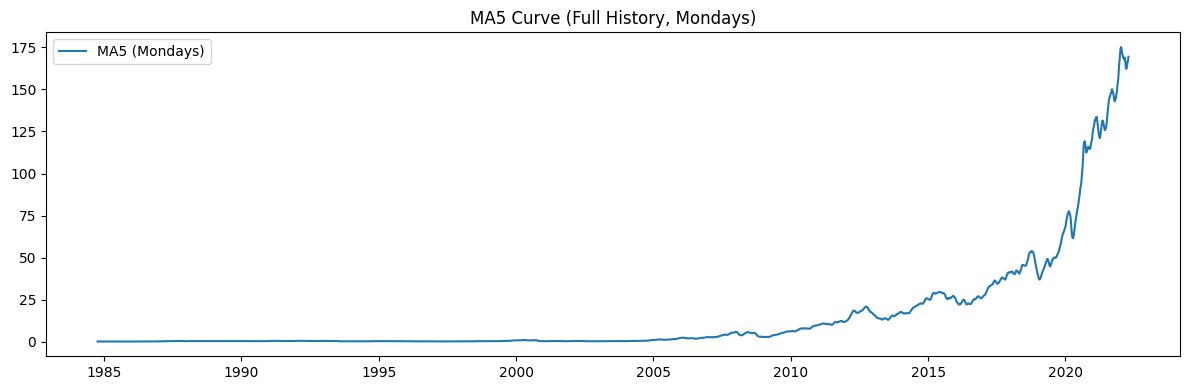

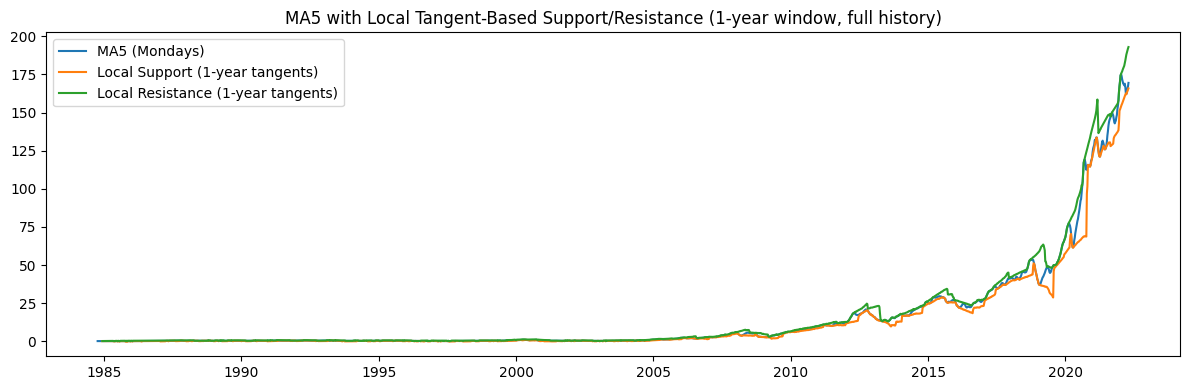

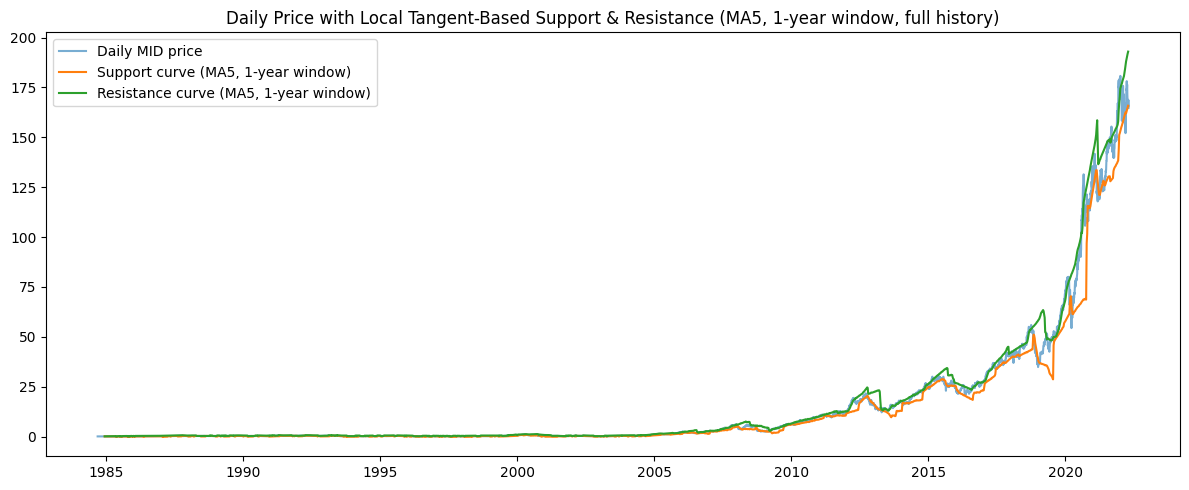

,DATE,MA5,SUPPORT,RESISTANCE
1954,2022-03-21,162.22263,161.995159,188.036063
1955,2022-03-28,163.32250,163.056813,189.392575
1956,2022-04-04,165.83050,163.995094,190.677403
1957,2022-04-11,166.87750,164.903485,191.927946
1958,2022-04-18,169.47234,165.856933,192.975510


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

apple = pd.read_csv(r"D:\data\notebooks\week-10\cleaned_apple_high_low.csv")
apple['DATE'] = pd.to_datetime(apple['DATE'], errors='coerce')
apple = apple.sort_values('DATE')

# Use FULL history (no 10-year cutoff)
subset = apple.copy()

# Compute daily MID price
subset['MID_HL'] = (subset['HIGH'] + subset['LOW']) / 2

# Keep Mondays only
mon = subset[subset['DATE'].dt.weekday == 0].copy()
mon = mon.sort_values('DATE').reset_index(drop=True)
mon['t'] = np.arange(len(mon))

# MA5 on Monday MID
window_ma = 5
mon['MA5'] = mon['MID_HL'].rolling(window=window_ma).mean()
mon2 = mon.dropna(subset=['MA5']).reset_index(drop=True)

t_all = mon2['t'].values
dates_all = mon2['DATE'].values
ma_all = mon2['MA5'].values

# Local 1-year tangent envelopes per Monday
support_vals = np.full(len(mon2), np.nan)
resistance_vals = np.full(len(mon2), np.nan)

for i in range(len(mon2)):
    date_i = mon2.loc[i, 'DATE']
    t_i = mon2.loc[i, 't']
    # 1-year lookback window (kept as-is)
    start_date = date_i - pd.Timedelta(days=365)
    mask = (mon2['DATE'] >= start_date) & (mon2['DATE'] <= date_i)
    window_df = mon2[mask]
    if len(window_df) < 10:
        # not enough points for stable tangent
        continue

    t = window_df['t'].values
    ma = window_df['MA5'].values

    # slope guess and search range
    slope_guess = (ma[-1] - ma[0]) / (t[-1] - t[0])
    m_candidates = np.linspace(slope_guess - 1, slope_guess + 1, 200)

    # Support (lower tangent) in this window
    best_s_m, best_s_b, best_s_score = None, None, -1e18
    for m in m_candidates:
        b = np.min(ma - m * t)
        line = m * t + b
        if np.all(line <= ma + 1e-9):
            score = line.mean()  # want as high as possible under MA
            if score > best_s_score:
                best_s_score = score
                best_s_m, best_s_b = m, b

    # Resistance (upper tangent) in this window
    best_r_m, best_r_b, best_r_score = None, None, 1e18
    for m in m_candidates:
        b = np.max(ma - m * t)
        line = m * t + b
        if np.all(line >= ma - 1e-9):
            score = line.mean()  # want as low as possible over MA
            if score < best_r_score:
                best_r_score = score
                best_r_m, best_r_b = m, b

    if best_s_m is not None:
        support_vals[i] = best_s_m * t_i + best_s_b
    if best_r_m is not None:
        resistance_vals[i] = best_r_m * t_i + best_r_b

mon2['SUPPORT'] = support_vals
mon2['RESISTANCE'] = resistance_vals

# Plot 1: MA5 curve (Mondays)
plt.figure(figsize=(12,4))
plt.plot(mon2['DATE'], mon2['MA5'], label='MA5 (Mondays)')
plt.title("MA5 Curve (Full History, Mondays)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: MA5 with local support & resistance curves (Mondays)
plt.figure(figsize=(12,4))
plt.plot(mon2['DATE'], mon2['MA5'], label='MA5 (Mondays)')
plt.plot(mon2['DATE'], mon2['SUPPORT'], label='Local Support (1-year tangents)')
plt.plot(mon2['DATE'], mon2['RESISTANCE'], label='Local Resistance (1-year tangents)')
plt.title("MA5 with Local Tangent-Based Support/Resistance (1-year window, full history)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Real daily MID price with Monday support/resistance curves
plt.figure(figsize=(12,5))
plt.plot(subset['DATE'], subset['MID_HL'], label='Daily MID price', alpha=0.6)
plt.plot(mon2['DATE'], mon2['SUPPORT'], label='Support curve (MA5, 1-year window)')
plt.plot(mon2['DATE'], mon2['RESISTANCE'], label='Resistance curve (MA5, 1-year window)')
plt.title("Daily Price with Local Tangent-Based Support & Resistance (MA5, 1-year window, full history)")
plt.legend()
plt.tight_layout()
plt.show()

mon2[['DATE','MA5','SUPPORT','RESISTANCE']].tail()


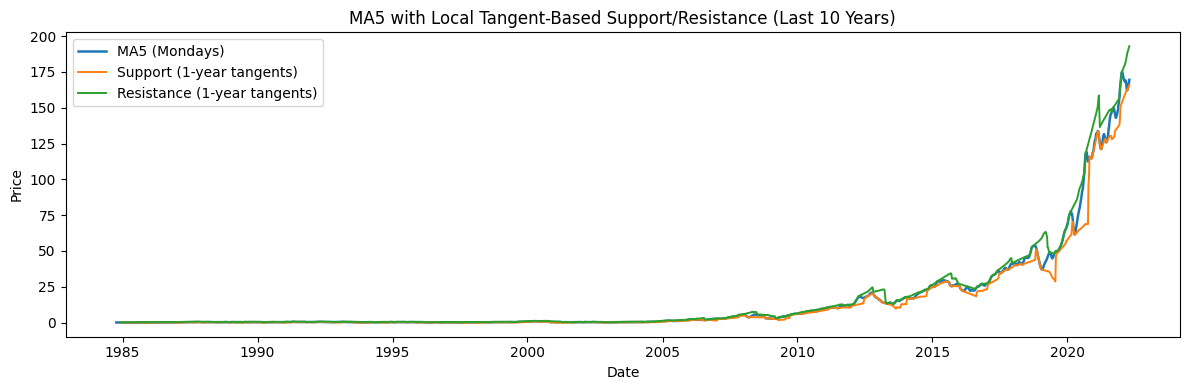

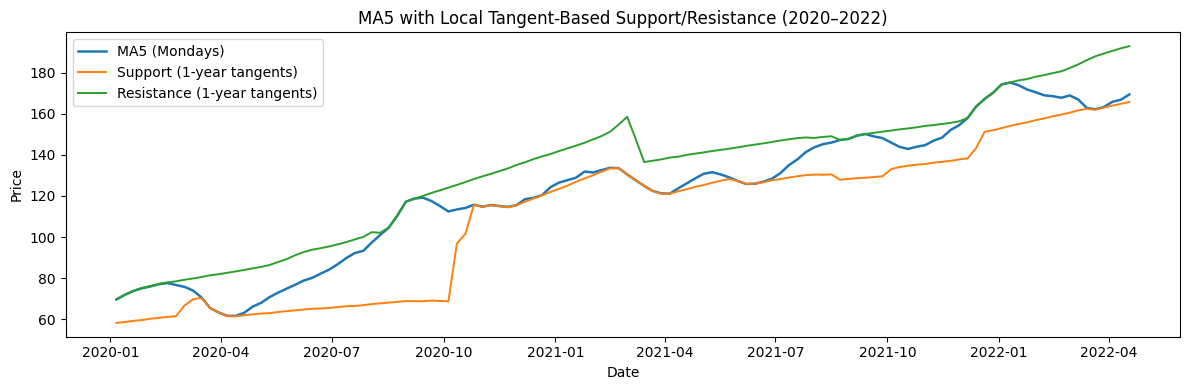

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Full period: MA5 + support/resistance (Mondays)

plt.figure(figsize=(12, 4))
plt.plot(mon2['DATE'], mon2['MA5'], label='MA5 (Mondays)', linewidth=1.8)
plt.plot(mon2['DATE'], mon2['SUPPORT'], label='Support (1-year tangents)', linewidth=1.4)
plt.plot(mon2['DATE'], mon2['RESISTANCE'], label='Resistance (1-year tangents)', linewidth=1.4)
plt.title('MA5 with Local Tangent-Based Support/Resistance (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Zoomed view: only 2020–2022 on smoothed curve

start_zoom = pd.Timestamp('2020-01-01')
end_zoom   = pd.Timestamp('2022-12-31')

mask_zoom = (mon2['DATE'] >= start_zoom) & (mon2['DATE'] <= end_zoom)
mon_zoom = mon2[mask_zoom]

plt.figure(figsize=(12, 4))
plt.plot(mon_zoom['DATE'], mon_zoom['MA5'], label='MA5 (Mondays)', linewidth=1.8)
plt.plot(mon_zoom['DATE'], mon_zoom['SUPPORT'], label='Support (1-year tangents)', linewidth=1.4)
plt.plot(mon_zoom['DATE'], mon_zoom['RESISTANCE'], label='Resistance (1-year tangents)', linewidth=1.4)
plt.title('MA5 with Local Tangent-Based Support/Resistance (2020–2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()



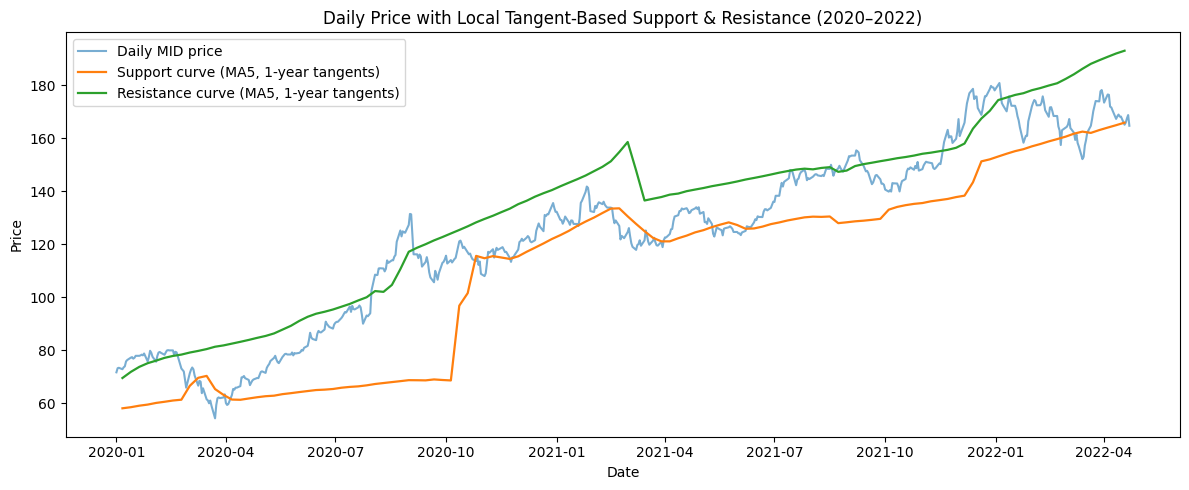

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have:
# subset: daily data with columns ['DATE', 'MID_HL']
# mon2  : Monday data with columns ['DATE', 'SUPPORT', 'RESISTANCE']

# --- Filter 2020–2022 range ---
start_zoom = pd.Timestamp('2020-01-01')
end_zoom   = pd.Timestamp('2022-12-31')

daily_zoom = subset[(subset['DATE'] >= start_zoom) & (subset['DATE'] <= end_zoom)]
mon_zoom   = mon2[(mon2['DATE'] >= start_zoom) & (mon2['DATE'] <= end_zoom)]

# --- Plot daily real data + support/resistance curves (2020–2022) ---
plt.figure(figsize=(12, 5))
plt.plot(daily_zoom['DATE'], daily_zoom['MID_HL'],
         label='Daily MID price', alpha=0.6)

# support/resistance only at Mondays, joined as curves
plt.plot(mon_zoom['DATE'], mon_zoom['SUPPORT'],
         label='Support curve (MA5, 1-year tangents)', linewidth=1.6)
plt.plot(mon_zoom['DATE'], mon_zoom['RESISTANCE'],
         label='Resistance curve (MA5, 1-year tangents)', linewidth=1.6)

plt.title('Daily Price with Local Tangent-Based Support & Resistance (2020–2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()
